<a href="https://colab.research.google.com/github/Emrekorkmz0/pistachio_leaf_classification.py/blob/main/leave_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import os
import keras

In [45]:
dir = '/content/drive/MyDrive/ALL_COLAB_FİLES/datasets/yaprak'
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[1]=='.jpg':
            if dirname.split()[-1]!='GT':
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','labels'])
df['path']=path
df['labels']=label

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2056 non-null   object
 1   labels  2056 non-null   object
dtypes: object(2)
memory usage: 32.2+ KB


In [47]:
df['labels']=df['labels'].astype('category')

In [48]:
df['labels'].value_counts()

,count
labels,
icterus,564
intact,534
dotted,492
dry,466


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
df['labels'].unique()

['dry', 'dotted ', 'icterus', 'intact']
Categories (4, object): ['dotted ', 'dry', 'icterus', 'intact']

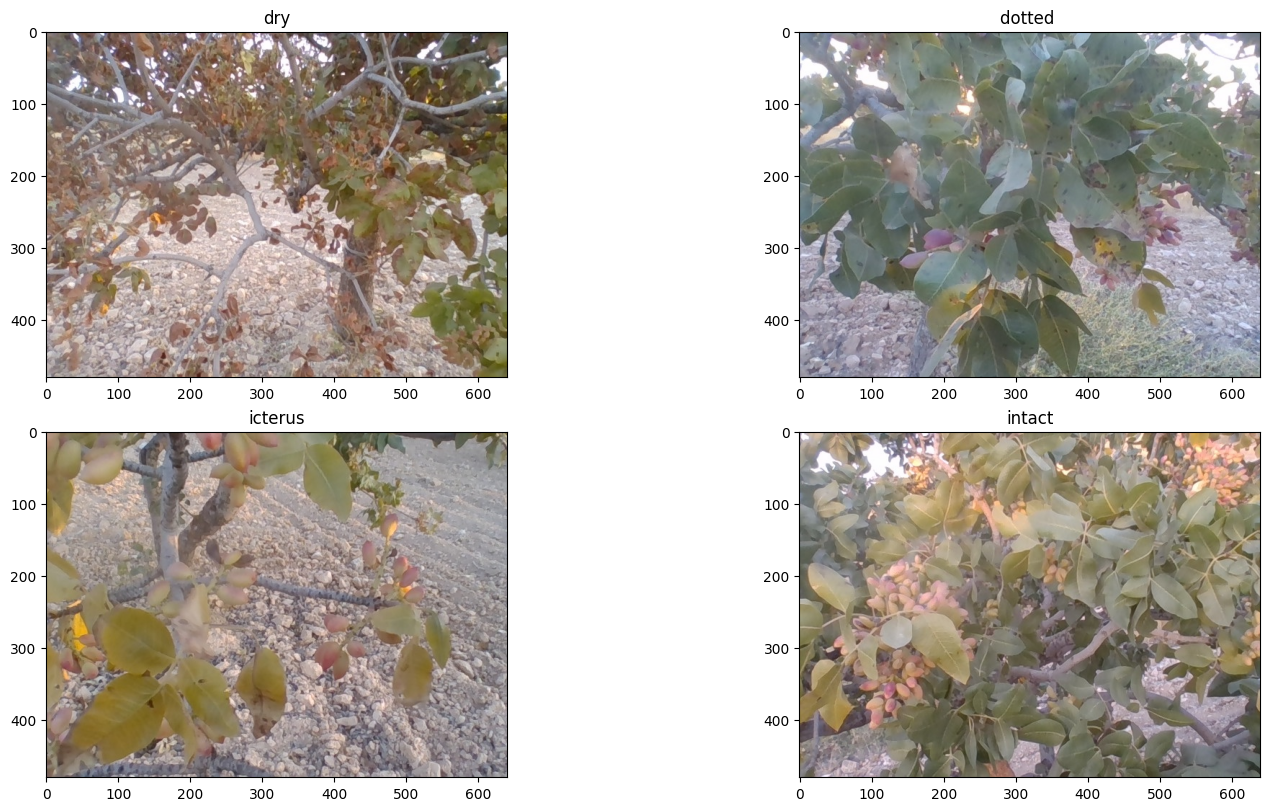

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['labels'].unique():

    ax[j].imshow(plt.imread(df[df['labels']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1


<Axes: xlabel='count', ylabel='labels'>

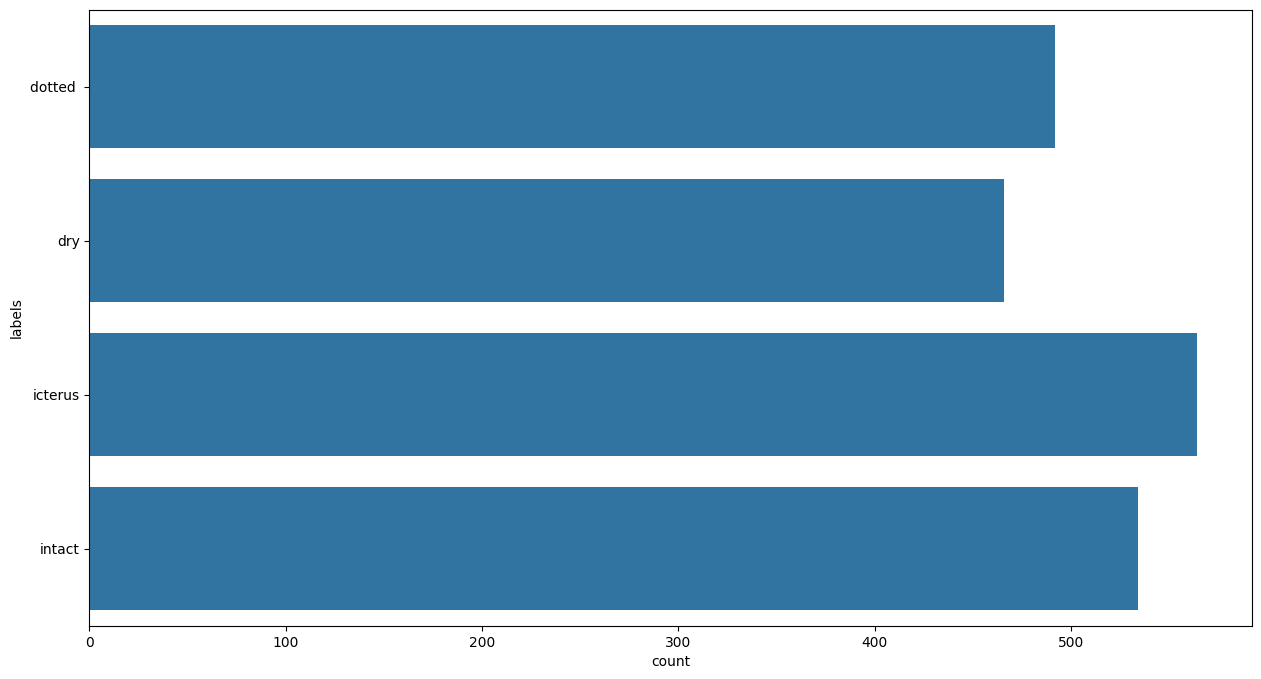

In [52]:
fig=plt.figure(figsize=(15,8))
sns.countplot(df['labels'])

In [53]:
plt.imread(df['path'][1]).shape

(480, 640, 3)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test=train_test_split(df, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1644, 2)
(412, 2)


In [55]:
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(preprocessing_function=preprocess_input,
                              zoom_range = 0.1,
                              horizontal_flip=True,
                              vertical_flip=True,
                              rotation_range=45,
                              validation_split=0.25)

testGen =ImageDataGenerator(preprocessing_function= preprocess_input)
X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='labels',class_mode='categorical', subset='training', color_mode='rgb', batch_size=32)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='labels',class_mode='categorical', subset='validation', color_mode='rgb', batch_size=32)
X_test_img =testGen.flow_from_dataframe(dataframe=X_test, x_col='path', y_col='labels',class_mode='categorical', color_mode='rgb', batch_size=32, shuffle=False)

Found 1233 validated image filenames belonging to 4 classes.
Found 411 validated image filenames belonging to 4 classes.
Found 412 validated image filenames belonging to 4 classes.


In [58]:
X_test_img[0][0].shape

(32, 256, 256, 3)

In [59]:
image_shape=(256,256,3)

In [60]:
X_train_img.class_indices

{'dotted ': 0, 'dry': 1, 'icterus': 2, 'intact': 3}

In [61]:
X_val_img.class_indices

{'dotted ': 0, 'dry': 1, 'icterus': 2, 'intact': 3}

In [62]:
X_test_img.class_indices

{'dotted ': 0, 'dry': 1, 'icterus': 2, 'intact': 3}

creating model


In [65]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras import layers
pre_trained= MobileNetV2(include_top=False, pooling='avg', input_shape=image_shape)

#for layers in pre_trained.layers:
#    layers.trainable=False
pre_trained.trainable=False

inp_model = pre_trained.input
"""
#x=Flatten()(pre_trained.output)
x=Dense(128, activation='relu')(pre_trained.output)
x=Dropout(0.5)(x)
x=Dense(128, activation='relu')(x)
output=Dense(4, activation='softmax')(x)
model = Model(inputs=inp_model, outputs=output)
"""



def build_mobilenet():
    model = Sequential()
    model.add(pre_trained)
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    #model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))


    model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

    return model

model=build_mobilenet()
#model.summary()


from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)

results = model.fit(X_train_img,epochs=30,
                              validation_data=X_val_img,
                                callbacks=[early_stop])

<ipython-input-65-c4f8cfe52352>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained= MobileNetV2(include_top=False, pooling='avg', input_shape=image_shape)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3474 - loss: 1.2515 - val_accuracy: 0.8102 - val_loss: 0.7144
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 638ms/step - accuracy: 0.6297 - loss: 0.8164 - val_accuracy: 0.9075 - val_loss: 0.4919
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 633ms/step - accuracy: 0.6207 - loss: 0.7539 - val_accuracy: 0.9197 - val_loss: 0.3376
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 638ms/step - accuracy: 0.7016 - loss: 0.6043 - val_accuracy: 0.9051 - val_loss: 0.3190
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 631ms/step - accuracy: 0.7403 - loss: 0.6208 - val_accuracy: 0.9294 - val_loss: 0.2912
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 636ms/step - accuracy: 0.7658 - loss: 0.5489 - val_accuracy: 0.9635 - val_loss: 0.1972
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - accuracy: 0.7874 - loss: 0.5056 - val_accuracy: 0.9781 - val_loss: 0.1430
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 633ms/step - accuracy: 0.8049 - loss: 0.4948 - val_accuracy: 0.9781 -

In [73]:
model.save('/content/drive/MyDrive/ALL_COLAB_FİLES/leaf_model.h5')

Text(0.5, 1.0, 'Loss')

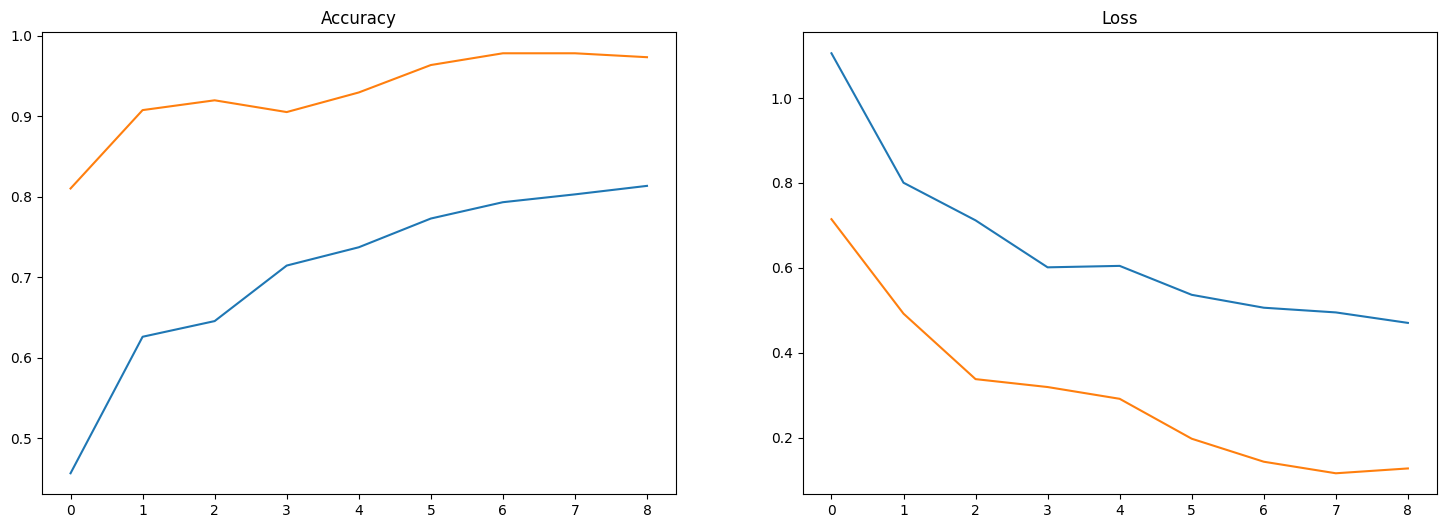

In [66]:
result=pd.DataFrame(results.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result[['loss','val_loss']])
ax[1].set_title("Loss")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step
Accuracy Score: 0.9757281553398058


<Axes: >

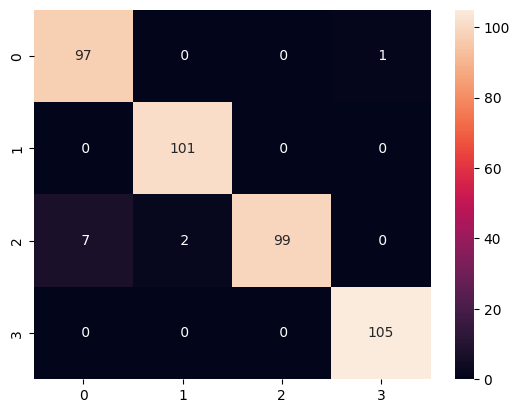

In [68]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'],pred_df['pred']), annot=True, fmt='2d')

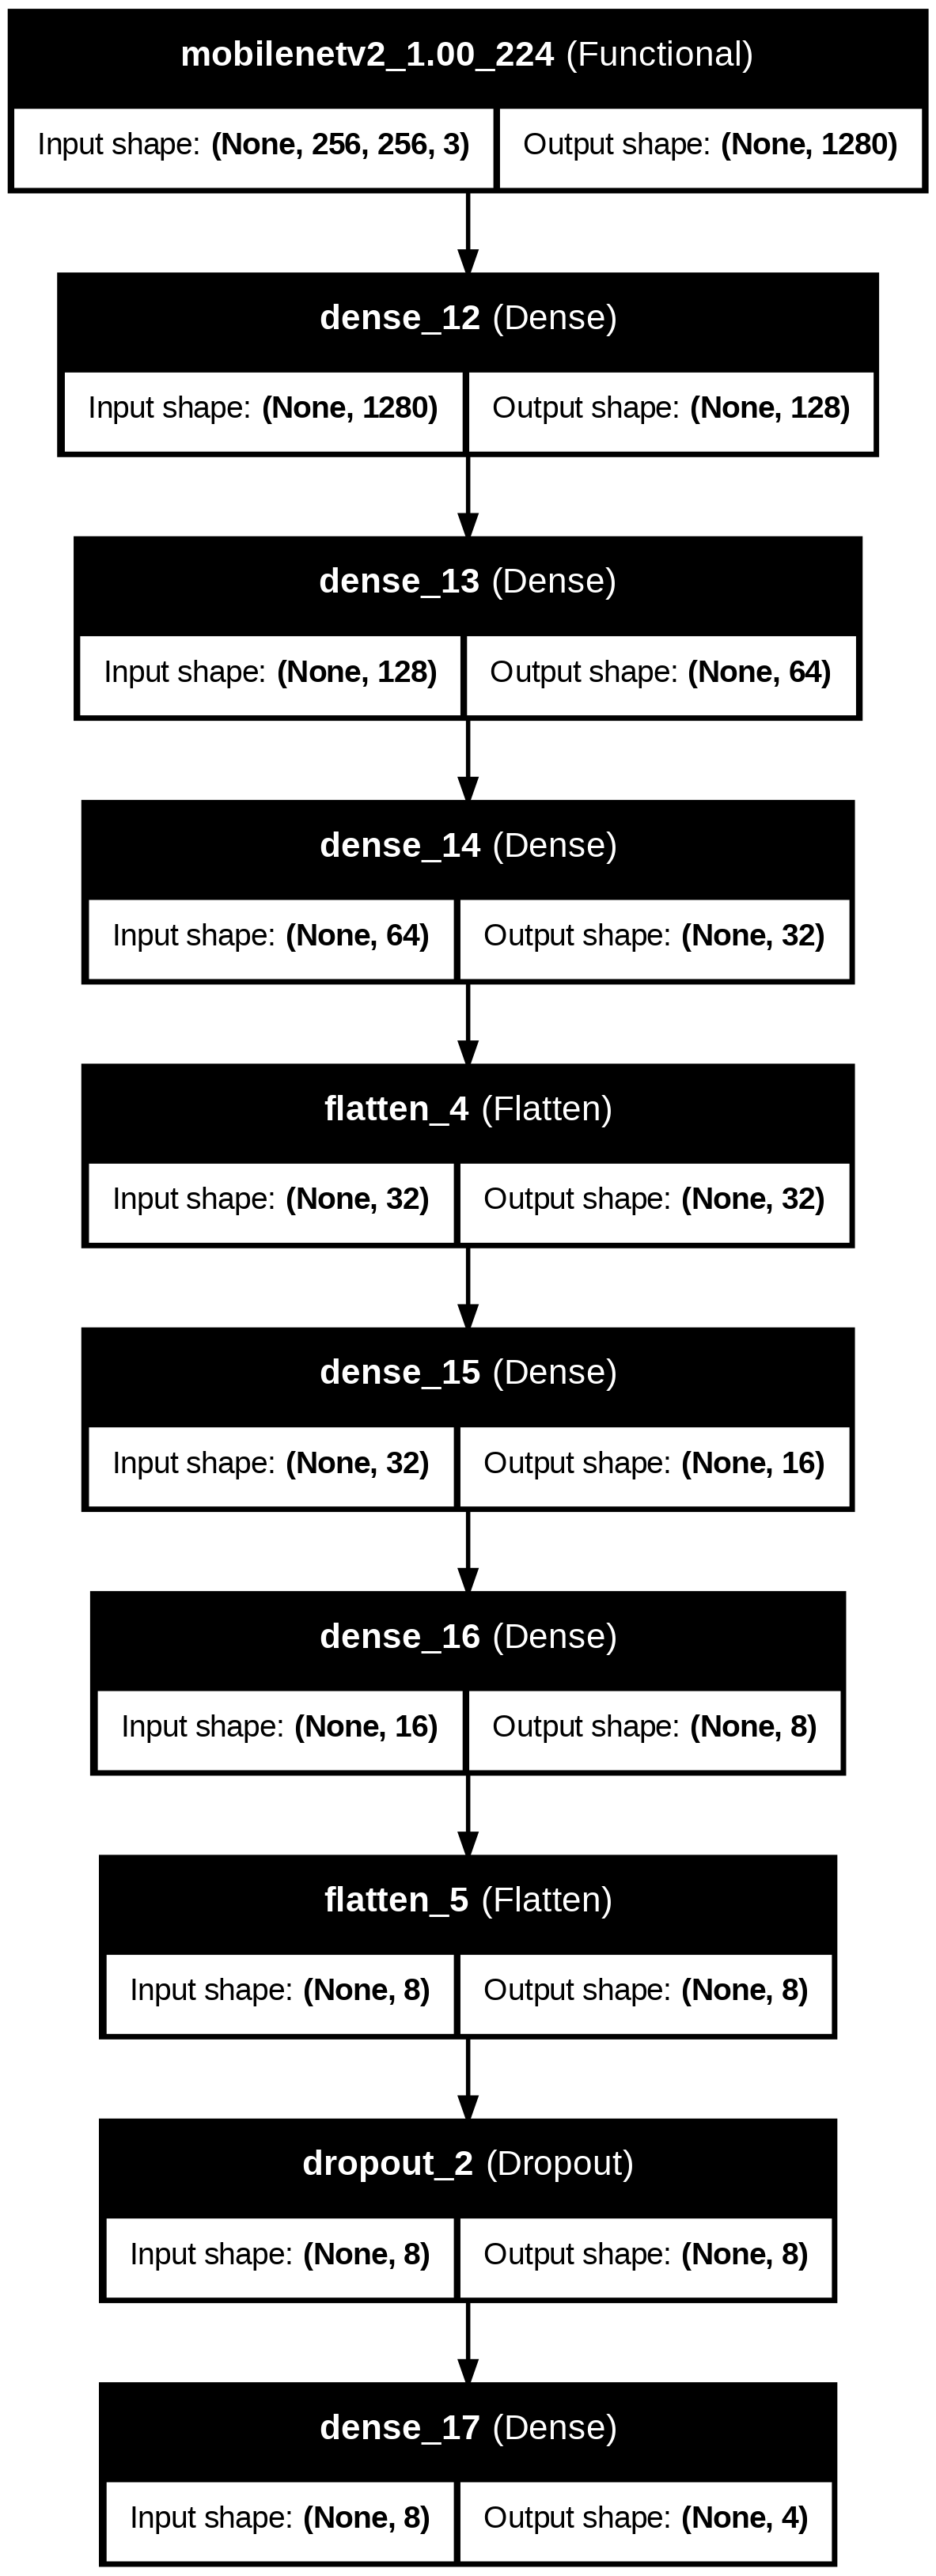

In [74]:
from keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

In [82]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 46.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


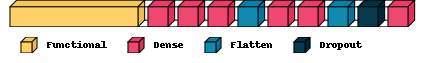

In [83]:
import visualkeras
visualkeras.layered_view(model, legend=True)